# Offline hand-eye callibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json
import sys
import glob

from apriltag import apriltag

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../offline_hand_eye")))
from calib_io_utils import save_calibration, load_calibration
from calibration_utils import load_and_detect, show_detections, compute_hand_eye_calibration, frame_is_valid, compute_TCP_image_position

In [2]:
data_root = '/mnt/data/cobot/realsense/calibration/calibdata_2025_08_11-11_51_22'
calibration_config_file = '../../../handeye_calibration_params.json'

with open(calibration_config_file, 'r') as f:
    calibration_config = json.load(f)

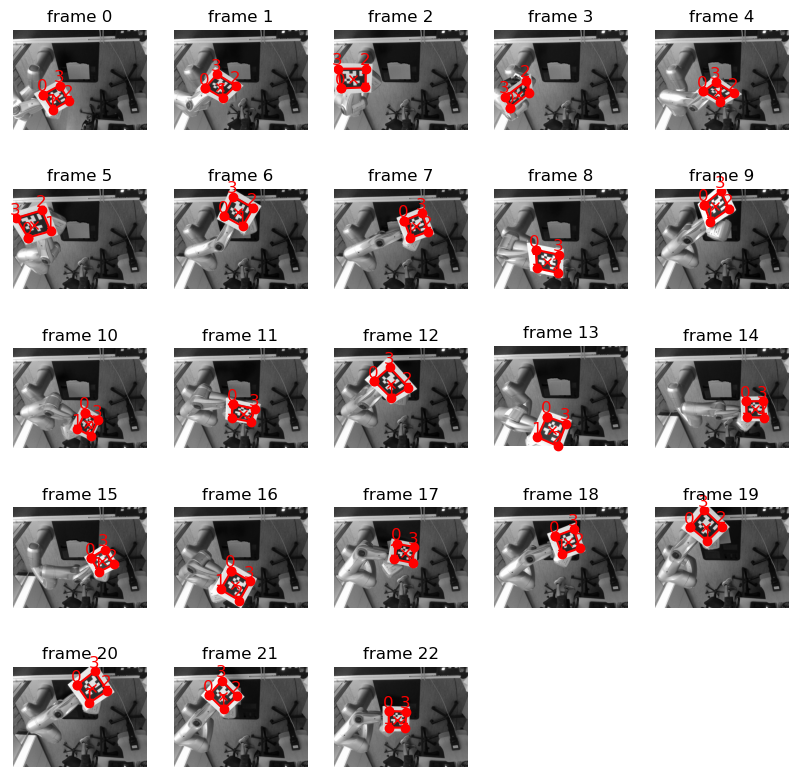

In [3]:
apriltag_family = 'tag36h11'
detector = apriltag(apriltag_family)

num_frames = len(glob.glob1(data_root, "frame_*.pkl"))
plt.figure(figsize=(10, 10))
for i, frame_count in enumerate(np.linspace(0, num_frames-1, min(num_frames, 25), dtype=int)): 
    frame, gray, detections = load_and_detect(frame_count, data_root, detector)

    plt.subplot(5, 5, i + 1)
    show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
    plt.title('frame %d' % frame_count)

In [4]:
frame, gray, detections = load_and_detect(10, data_root, detector)
frame

{'image_timestamp': (1754913281, 881792236),
 'robot_transform': OrderedDict([('translation',
               OrderedDict([('x', 0.5927182330326759),
                            ('y', 0.9605102301348581),
                            ('z', 0.017515726128091158)])),
              ('rotation',
               OrderedDict([('x', 0.848245601608102),
                            ('y', 0.21850021141091713),
                            ('z', -0.4217332821607434),
                            ('w', 0.23426074294217644)]))]),
 'tracking_transform': None,
 'camera_info': OrderedDict([('header',
               OrderedDict([('stamp',
                             OrderedDict([('sec', 1754913281),
                                          ('nanosec', 481502441)])),
                            ('frame_id', 'camera_color_optical_frame')])),
              ('height', 480),
              ('width', 640),
              ('distortion_model', 'plumb_bob'),
              ('d', [0.0, 0.0, 0.0, 0.0, 0.0]),
          

In [5]:
#frame_samples = [0, 3, 13, 16, 27, 30, 33, 37, 40, 47, 54, 64, 70, 77]
#frame_samples = [0, 2, 6, 10, 19, 22, 26, 29, 31, 33, 35, 36, 37, 39, 41, 47, 53, 64, 72, 78]
#frame_samples = [18, 19, 20, 21, 22, 23, 24, 25, 26]
frame_samples = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for frame_count in frame_samples:
    frame, gray, detections = load_and_detect(frame_count, data_root, detector)
    if not frame_is_valid(frame, detections):
        print(f"Error: Invalid frame {frame_count}")

In [6]:
tagsize = 0.14  # Size of the tag in meters
hand_camera_rot, hand_camera_tr, hand_camera_qwxyz = compute_hand_eye_calibration(data_root, frame_samples, detector, tagsize)

print("Hand-Eye Calibration Results:")
print("Rotation Matrix:")
print(hand_camera_rot)
print("Quaternion (wxyz):")
print(hand_camera_qwxyz)
print("Translation Vector:")
print(hand_camera_tr)

Hand-Eye Calibration Results:
Rotation Matrix:
[[-0.99009886  0.00133513  0.14036546]
 [ 0.09907168  0.71504506  0.69202266]
 [-0.09944369  0.69907709 -0.70809757]]
Quaternion (wxyz):
[0.06490113 0.02717376 0.923748   0.37648248]
Translation Vector:
[[-0.62374292]
 [-0.46101675]
 [ 1.53653253]]


Reference: 

```bash
Hand-Eye Calibration Results:
Rotation Matrix:
[[ 0.99084876 -0.06789273 -0.11665893]
 [ 0.05717175  0.99403161 -0.09291156]
 [ 0.12227068  0.08539171  0.98881653]]
Quaternion (wxyz):
[ 0.99670669  0.04472311 -0.05992977  0.03136943]
Translation Vector:
[[-0.25556454]
 [ 0.50022198]
 [ 1.02821659]]
```

In [7]:
calibration_file = '../../../handeye_calibration.json'
save_calibration(calibration_file, calibration_config, hand_camera_qwxyz.tolist(), hand_camera_tr.tolist(), 
                 frame_samples, data_root)

loaded_calibration = load_calibration(calibration_file)
print("Loaded Calibration:")
print(loaded_calibration)   

Loaded Calibration:
{'calibration_type': 'eye_on_base', 'robot_base_frame': 'base_link', 'robot_effector_frame': 'TCP', 'tracking_base_frame': 'camera_color_optical_frame', 'translation': [[-0.6237429195657751], [-0.46101674778952517], [1.536532534912803]], 'rotation_q_wxyz': [0.06490112776082659, 0.027173756125176335, 0.9237480029370863, 0.37648247988872907], 'selected_samples': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'data_file_path': '/mnt/data/cobot/realsense/calibration/calibdata_2025_08_11-11_51_22'}


## Stability testing

In [8]:
samples = frame_samples
for i in range(5):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples, detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('permutation=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())
    samples = np.random.permutation(frame_samples)

permutation=00 : rotation:  [0.08201208 2.78792882 1.1362475 ] , translation:  [-0.62374292 -0.46101675  1.53653253]
permutation=01 : rotation:  [0.08201208 2.78792882 1.1362475 ] , translation:  [-0.6262314  -0.46063518  1.53809646]
permutation=02 : rotation:  [0.08201208 2.78792882 1.1362475 ] , translation:  [-0.62315164 -0.46143633  1.53533028]
permutation=03 : rotation:  [0.08201208 2.78792882 1.1362475 ] , translation:  [-0.62578369 -0.46041404  1.53866746]
permutation=04 : rotation:  [0.08201208 2.78792882 1.1362475 ] , translation:  [-0.62514588 -0.46079838  1.5379813 ]


In [9]:
samples = np.random.permutation(frame_samples)
for i in range(5, len(samples)+1):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples[:i], detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('len=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())


len=05 : rotation:  [0.0134818  2.79169594 1.14167616] , translation:  [-0.62283415 -0.47949747  1.56788141]
len=06 : rotation:  [0.03999003 2.79432095 1.1163602 ] , translation:  [-0.63450707 -0.46608552  1.56554683]
len=07 : rotation:  [0.05088219 2.78779146 1.10184257] , translation:  [-0.63899073 -0.45818526  1.55889013]
len=08 : rotation:  [0.05104999 2.78848153 1.10034266] , translation:  [-0.64164163 -0.46231243  1.56390025]
len=09 : rotation:  [0.04327567 2.78702546 1.11508235] , translation:  [-0.6325352  -0.46486851  1.55800236]
len=10 : rotation:  [0.04138392 2.78766732 1.11756452] , translation:  [-0.63016476 -0.4664809   1.55549238]
len=11 : rotation:  [0.03614417 2.78902555 1.11802478] , translation:  [-0.62235164 -0.46379822  1.55212121]
len=12 : rotation:  [0.03327957 2.78729082 1.12334952] , translation:  [-0.62078714 -0.46191078  1.55023773]
len=13 : rotation:  [0.04564725 2.78560374 1.13639505] , translation:  [-0.62274617 -0.46677168  1.54810104]
len=14 : rotation: 

## Reprojection test

(array([[-0.38368047],
        [ 0.16607222],
        [ 0.92492452]]),
 array([242.1208371 , 269.51421508]))

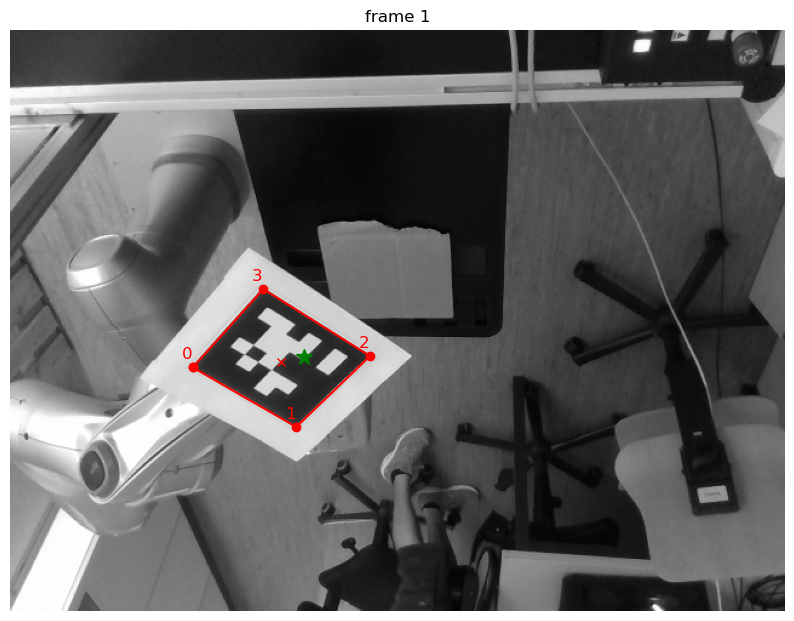

In [11]:
frame_count = 1
frame, gray, detections = load_and_detect(frame_count, data_root, detector)
assert frame_is_valid(frame, detections), f"Frame {frame_count} is invalid"

plt.figure(figsize=(10, 10))
show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
plt.title('frame %d' % frame_count)

img_points, TCP_world = compute_TCP_image_position(frame, hand_camera_rot, hand_camera_tr)
plt.plot(img_points[0], img_points[1], 'g*', ms=12, label='TCP Projection')

TCP_world, img_points